In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting, compute_r2_score
_FOLDER = "./data/"

### normalised_dose_response_data.csv

In [3]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [4]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

### Filtering

**Filtering_curves**
<br>(df, response_columns, filtering_scenario = [1,2,3], 
     first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, 
     first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

    filtering_scenario = [1,2,3]
    1. Ensure that all the response are less than 1
    
    2. Ensure that first and last points form a plateu
    the minimal number of points are specified in the function arguments
    by default, two points for both lpateus are considered
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first two columns for plateu
    last_columns_to_compare = [-1, -2] - last two columns for plateu
    
    3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

In [10]:
def FittedData(df, x_columns, y_columns, fitting_function, parameters_guess=[], default_param = True):
    
    r2, fit_param = FittingColumn(df, df.index, x_columns, y_columns, fitting_function, default_param = True)
    df["fitting_r2"] = r2
    df["fitting_param"] = fit_param
    df= df[df["fitting_r2"]!=0]
    return df

def TransposeCellFeatures(df, indexes_first_column = True):
    # columns in cell_features correspond to drug_curves["COSMIC_ID"] == cell line id
    if indexes_first_column:
        df_transfromed = pd.DataFrame(data= df[df.columns[1:]].values.T,
                          index= df.columns[1:], columns= df[df.columns[0]].values)
    else:
        print("The logic of this function is not applicable")
        
    return df_transfromed 

def PrepareDrugMerge(df):
    """Column fitting_param is splitted into separate columns """
    conc_columns= ["fd_num_"+str(i) for i in range(10)]
    response_norm = ['norm_cells_'+str(i) for i in range(10)]
    param_cols = ["DRUG_ID"] + conc_columns + response_norm
    for i in range(len(df['fitting_param'].values[0])):
        param_col = "param_"+str(i+1)
        param_cols.append(param_col)
        df[param_col] = df['fitting_param'].apply(lambda x: x[i])
    param_cols.insert(0, "COSMIC_ID")
    return df[param_cols]
    

def MergeDrugCells(df_drugs, df_cells):
    cell_features_T = TransposeCellFeatures(df_cells)
    cell_features_T.index = np.array(cell_features_T.index, dtype = "int")
    
    # Not all the drugs from filtered dataset are present in cell lines features
    common_cells_drug = list(set(np.array(df_cells.columns[1:], dtype="int"))& set(df_drugs["COSMIC_ID"].values))
    
    # print("Number of drugs in filtered dataset:", df_328["COSMIC_ID"].nunique())
    # print("Number of common drugs in both datasets", len(common_cells_drug328))

    cell_lines = cell_features_T.loc[common_cells_drug, :].reset_index()
    cell_lines.rename(columns = {"index": "COSMIC_ID"}, inplace=True)
    
    df_drug_param = PrepareDrugMerge(df_drugs)
    
    return pd.merge(left=df_drug_param, right = cell_lines, on = "COSMIC_ID") 

In [11]:
%%time
df123 = FilteringCurves(drug_curves, response_norm, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
CPU times: user 984 ms, sys: 259 ms, total: 1.24 s
Wall time: 1.61 s


In [12]:
not_fitted_df = df123.copy()
fitting_function = "sigmoid_4_param"
df = FittedData(not_fitted_df, x_columns=conc_columns, y_columns= response_norm, 
                fitting_function=fitting_function, default_param=True)
print("Fitted data with removed unfit", df.shape)

100%|██████████| 2776/2776 [00:10<00:00, 263.22it/s]

Fitted data with removed unfit (2771, 48)


Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


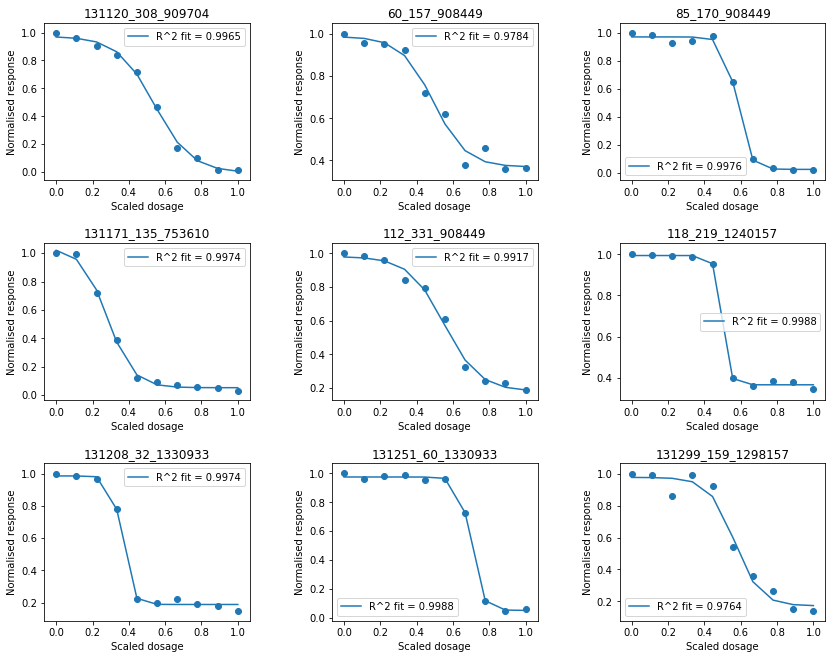

In [15]:
fitting_function = "sigmoid_4_param"
fit_columns = "fitting_param"

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fit_columns)

In [16]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, cell_features)

### Linear kernel

In [11]:
%%time

# Check the errors for all drugs
param_tested = [0.1, 0.5, 1, 5]
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index
test_data= merged_df.head(1).copy()
df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='linear', alpha = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


CPU times: user 6.91 s, sys: 524 ms, total: 7.43 s
Wall time: 5.11 s


In [12]:
# x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b
df_errors.describe().loc[["mean", "min","max"], :]

,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_1_5,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_2_5,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_3_5,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1,mse_param_4_5
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,8.247956,8.115017,8.013559,7.665898,9.984646,9.909203,9.846273,9.614483,308.304996,302.208408,295.837899,269.437589,1.191177,1.180108,1.168066,1.103946
std,14.102608,13.995730,13.945249,13.857578,45.544633,45.522806,45.502120,45.375131,459.868254,455.288111,451.383736,445.442168,3.128437,3.114892,3.098603,2.990682
min,0.004183,0.004269,0.004379,0.005442,0.031759,0.031463,0.031123,0.029683,9.306338,9.308458,9.340772,8.847061,0.000131,0.000125,0.000117,0.000087
25%,0.337420,0.324071,0.311138,0.267969,0.607833,0.599273,0.556592,0.561805,43.240982,42.601576,42.763917,39.325656,0.028363,0.028021,0.027527,0.023918
50%,3.579695,3.556818,3.537470,3.185112,1.428141,1.383253,1.288763,1.244812,98.820676,97.516030,96.584055,88.132296,0.108050,0.106817,0.105442,0.108213
75%,9.502414,9.374671,9.309115,8.783301,3.310212,3.249022,3.203184,2.827731,350.358001,339.163844,326.305813,304.894805,0.502074,0.502230,0.502366,0.412612
max,101.886036,101.904996,101.928527,102.107511,361.988747,361.821834,361.621093,360.262002,2296.590882,2310.277385,2326.835350,2446.213022,18.098037,17.953930,17.775064,16.523842


Mean Squared errors for 70 drugs
Parameter 1 == x0
DRUG_ID
11    6.470579
41    0.110301
Name: mse_param_1_0.1, dtype: float64
DRUG_ID
11    6.573119
41    0.111090
Name: mse_param_1_0.5, dtype: float64
DRUG_ID
11    6.670359
41    0.112169
Name: mse_param_1_1, dtype: float64
DRUG_ID
11    6.997048
41    0.120590
Name: mse_param_1_5, dtype: float64


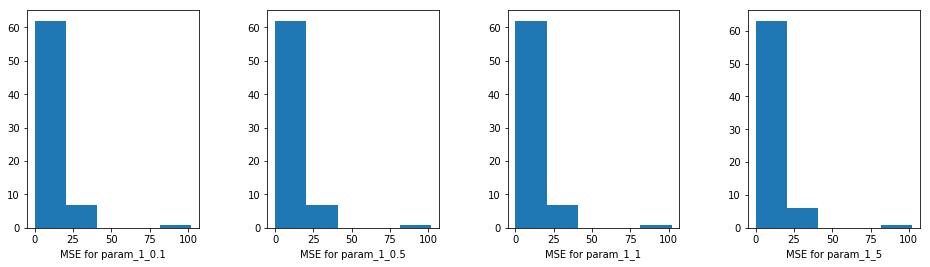

In [22]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
print("Parameter 1 == x0")
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    print(df_errors[parameters_to_show[0]+"_"+str(param_tested[i])].head(2))
    ax.hist(df_errors[parameters_to_show[0]+"_"+str(param_tested[i])], bins=5)
    ax.set_xlabel("MSE for param_1"+"_"+str(param_tested[i]))

Mean Squared errors for 70 drugs
Parameter 2 == L (L=1 in Wang's paper)
DRUG_ID
11    2.380368
41    0.386769
Name: mse_param_2_0.1, dtype: float64
DRUG_ID
11    2.296253
41    0.389348
Name: mse_param_2_0.5, dtype: float64
DRUG_ID
11    2.235061
41    0.392860
Name: mse_param_2_1, dtype: float64
DRUG_ID
11    2.142722
41    0.420670
Name: mse_param_2_5, dtype: float64


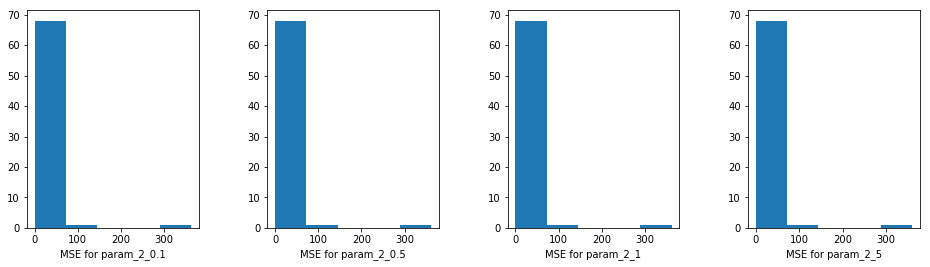

In [19]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
print("Parameter 2 == L (L=1 in Wang's paper)")
for i in range(n_plots):
    print(df_errors[parameters_to_show[1]+"_"+str(param_tested[i])].head(2))
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[1]+"_"+str(param_tested[i])], bins=5)
    ax.set_xlabel("MSE for param_2"+"_"+str(param_tested[i]))

Mean Squared errors for 70 drugs
Parameter 3 == k (-1/s in Wang's paper)
DRUG_ID
11     98.330780
41    215.016006
Name: mse_param_3_0.1, dtype: float64
DRUG_ID
11     81.200447
41    214.793736
Name: mse_param_3_0.5, dtype: float64
DRUG_ID
11     68.757950
41    214.758217
Name: mse_param_3_1, dtype: float64
DRUG_ID
11     48.135208
41    217.394581
Name: mse_param_3_5, dtype: float64


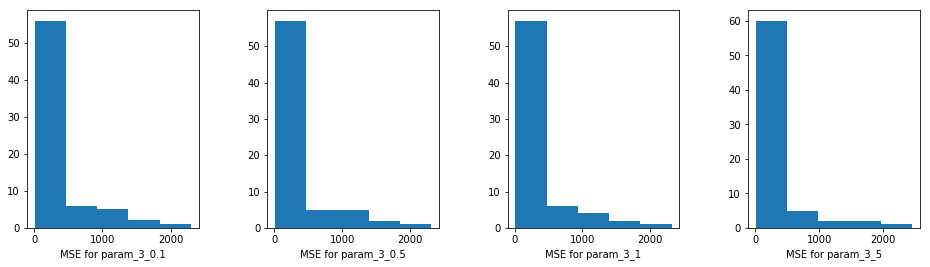

In [20]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
print("Parameter 3 == k (-1/s in Wang's paper)")
for i in range(n_plots):
    print(df_errors[parameters_to_show[2]+"_"+str(param_tested[i])].head(2))
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[2]+"_"+str(param_tested[i])], bins=5)
    ax.set_xlabel("MSE for param_3"+"_"+str(param_tested[i]))

Mean Squared errors for 70 drugs
Parameter 4 == b (b=0 in Wang's paper)
DRUG_ID
11    0.093671
41    0.021362
Name: mse_param_4_0.1, dtype: float64
DRUG_ID
11    0.097516
41    0.021413
Name: mse_param_4_0.5, dtype: float64
DRUG_ID
11    0.101428
41    0.021476
Name: mse_param_4_1, dtype: float64
DRUG_ID
11    0.116927
41    0.021949
Name: mse_param_4_5, dtype: float64


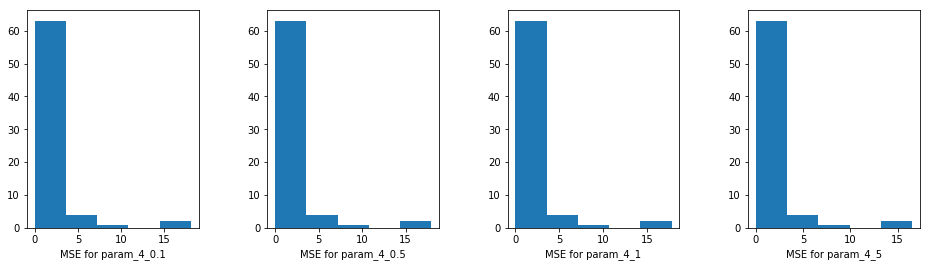

In [21]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
print("Parameter 4 == b (b=0 in Wang's paper)")
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    print(df_errors[parameters_to_show[3]+"_"+str(param_tested[i])].head(2))
    ax.hist(df_errors[parameters_to_show[3]+"_"+str(param_tested[i])], bins=5)
    ax.set_xlabel("MSE for param_4"+"_"+str(param_tested[i]))

### Sigmoid Kernel

In [25]:
%%time

# Check the errors for all drugs
param_tested = [0.1, 0.5, 1, 5]
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_1_5,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_2_5,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_3_5,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1,mse_param_4_5
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.688567,7.403801,13.797965,9.501385,9.323580,9.583435,13.291688,10.859396,187.912515,223.070462,250.275777,287.510302,0.920202,0.951009,1.051763,1.253547
std,13.080504,14.110683,46.292369,17.347415,46.446226,46.565321,51.358712,46.949148,359.813346,438.879337,441.405681,543.708752,2.569277,2.606233,2.708535,3.350559
min,0.004616,0.003449,0.003462,0.003593,0.001846,0.001925,0.001927,0.001979,4.149136,4.095317,3.768209,3.570443,0.000050,0.000048,0.000044,0.000042
25%,0.182668,0.168892,0.169999,0.162418,0.223095,0.211564,0.205337,0.197407,20.421416,19.538705,19.658409,19.566068,0.016264,0.016969,0.018129,0.018075
50%,3.145366,3.379784,3.547392,3.834398,0.924573,0.980421,1.015030,1.118137,55.333753,59.709786,66.933296,67.965899,0.086239,0.088887,0.088800,0.092752
75%,7.987157,8.062300,8.804627,8.765375,2.699926,2.597214,2.485838,2.650376,181.214750,197.084353,229.124548,233.850052,0.255757,0.271460,0.284671,0.289743
max,99.724795,99.615158,361.146437,99.356996,369.479897,370.263682,369.995236,369.833725,1883.838520,2231.695530,2077.056242,2764.832868,14.502308,14.515535,14.497715,17.042117


mse_param_1_0.1, gamma = 0.1:
    - the lowest mean mse, compatible min and max errors
    mean is 6.688567

In [28]:
%%time

# Check the errors for all drugs
param_tested = [0.001, 0.01, 0.1, 0.2]
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae
df_errors.describe()

CPU times: user 7.22 s, sys: 473 ms, total: 7.69 s
Wall time: 5.27 s


,mse_param_1_0.001,mse_param_1_0.01,mse_param_1_0.1,mse_param_1_0.2,mse_param_2_0.001,mse_param_2_0.01,mse_param_2_0.1,mse_param_2_0.2,mse_param_3_0.001,mse_param_3_0.01,mse_param_3_0.1,mse_param_3_0.2,mse_param_4_0.001,mse_param_4_0.01,mse_param_4_0.1,mse_param_4_0.2
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.503608,6.546305,6.688567,6.700744,9.220356,9.234976,9.323580,9.343074,179.361106,180.485233,187.912515,196.377191,0.867080,0.879284,0.920202,0.923011
std,13.004356,13.031057,13.080504,13.072464,46.435283,46.412092,46.446226,46.510335,373.729984,370.950130,359.813346,366.895390,2.479901,2.504857,2.569277,2.561906
min,0.003655,0.004214,0.004616,0.004642,0.002911,0.002448,0.001846,0.001997,5.164186,5.180421,4.149136,3.811020,0.000041,0.000042,0.000050,0.000052
25%,0.141392,0.150984,0.182668,0.179428,0.194796,0.188467,0.223095,0.198543,18.212685,18.404385,20.421416,19.398127,0.014753,0.014469,0.016264,0.016454
50%,2.860992,2.978444,3.145366,3.186999,0.876527,0.910438,0.924573,0.872619,54.986089,56.496595,55.333753,55.202404,0.076284,0.075655,0.086239,0.088342
75%,8.289998,8.202632,7.987157,7.682777,2.435352,2.551663,2.699926,2.662685,131.105219,130.572347,181.214750,191.993271,0.242987,0.252033,0.255757,0.279731
max,99.564713,99.618105,99.724795,99.717780,368.975600,368.866004,369.479897,370.042135,2008.637365,1978.100920,1883.838520,1898.211564,14.486819,14.489615,14.502308,14.512522


mse_param_1_0.001, gamma = 0.001:
    - the lowest mean mse, compatible min and max errors

In [32]:
%%time

# Check the errors for all drugs
param_tested = [0.00001, 0.0001, 0.001]
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

,mse_param_1_1e-05,mse_param_1_0.0001,mse_param_1_0.001,mse_param_2_1e-05,mse_param_2_0.0001,mse_param_2_0.001,mse_param_3_1e-05,mse_param_3_0.0001,mse_param_3_0.001,mse_param_4_1e-05,mse_param_4_0.0001,mse_param_4_0.001
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.499940,6.500235,6.503608,9.221225,9.221089,9.220356,179.270464,179.276968,179.361106,0.865613,0.865747,0.867080
std,13.000686,13.001026,13.004356,46.439146,46.438779,46.435283,374.134662,374.095875,373.729984,2.476617,2.476921,2.479901
min,0.003593,0.003599,0.003655,0.002985,0.002978,0.002911,5.164119,5.164105,5.164186,0.000041,0.000041,0.000041
25%,0.140907,0.140952,0.141392,0.193590,0.193703,0.194796,18.288505,18.281228,18.212685,0.014842,0.014834,0.014753
50%,2.842976,2.844670,2.860992,0.871955,0.872382,0.876527,54.886624,54.896073,54.986089,0.077303,0.077201,0.076284
75%,8.345401,8.339843,8.289998,2.424279,2.425311,2.435352,130.810949,130.925676,131.105219,0.241610,0.241740,0.242987
max,99.558253,99.558842,99.564713,368.999913,368.997547,368.975600,2013.128364,2012.705948,2008.637365,14.486419,14.486456,14.486819


**the best parameter for gamma is 0.00001** mean is 6.499940	

### Sigmoid kernel with regularisation

In [42]:
%%time

# Check the errors for all drugs
param_tested = [0.1, 0.5, 1, 5] #regularisation alpha default value is 1
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma= 0.00001, alpha = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 5.95 s, sys: 394 ms, total: 6.35 s
Wall time: 3.86 s


,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_1_5,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_2_5,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_3_5,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1,mse_param_4_5
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.516887,6.506066,6.499940,6.571999,9.277695,9.249844,9.221225,9.119591,178.872712,178.664995,179.270464,197.180260,0.866662,0.865999,0.865613,0.868242
std,12.896284,12.945167,13.000686,13.297860,46.761891,46.608309,46.439146,45.608485,355.119136,363.270596,374.134662,457.383802,2.469133,2.472451,2.476617,2.502835
min,0.001126,0.002318,0.003593,0.015617,0.000278,0.002596,0.002985,0.006929,4.565417,4.637231,5.164119,6.964181,0.000047,0.000044,0.000041,0.000035
25%,0.217046,0.183320,0.140907,0.060240,0.165398,0.176950,0.193590,0.348465,22.378481,20.865696,18.288505,26.314489,0.016206,0.015260,0.014842,0.015197
50%,2.918896,2.918788,2.842976,2.575157,0.877594,0.874342,0.871955,0.913443,55.986854,56.259206,54.886624,56.580294,0.077681,0.077631,0.077303,0.075135
75%,8.510722,8.414923,8.345401,7.779580,2.469343,2.443796,2.424279,2.247537,147.757008,138.352334,130.810949,101.640265,0.246819,0.248886,0.241610,0.192008
max,98.948956,99.237386,99.558253,101.182017,371.834907,370.483148,368.999913,361.812433,1988.384318,1999.434528,2013.128364,2680.065946,14.450058,14.467114,14.486419,14.589975


**default value of regularisation strength alpha=1 is the best** mean is 6.499940

### Sigmoid kernel with coef0

In [43]:
%%time

# Check the errors for all drugs
param_tested = [-0.1, 0, 0.1, 0.5, 1] # coef0 default value is 0
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma= 0.00001, alpha = 1, coef0 = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 8.24 s, sys: 512 ms, total: 8.76 s
Wall time: 5.91 s


,mse_param_1_-0.1,mse_param_1_0,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_2_-0.1,mse_param_2_0,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_3_-0.1,mse_param_3_0,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_4_-0.1,mse_param_4_0,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,5306.770809,7.993988,6.650930,6.500543,6.499940,3229.238519,9.337887,9.103125,9.192127,9.221225,2.523153e+05,445.328408,211.466629,181.031208,179.270464,164.792083,0.953455,0.871771,0.865522,0.865613
std,38225.865647,14.338152,13.416982,13.064545,13.000686,15826.378570,43.939298,45.313239,46.250257,46.439146,1.172152e+06,784.935507,498.226292,388.702971,374.134662,965.286367,2.703134,2.515875,2.481696,2.476617
min,0.117372,0.102964,0.006855,0.006697,0.003593,0.049540,0.772335,0.025510,0.009272,0.002985,2.807222e+01,42.162376,8.281708,5.719349,5.164119,0.000444,0.000049,0.000036,0.000039,0.000041
25%,4.132219,0.354608,0.069617,0.126883,0.140907,2.024591,1.269749,0.467724,0.217919,0.193590,2.768839e+02,86.857573,27.409125,20.270564,18.288505,0.100989,0.037918,0.017390,0.016331,0.014842
50%,10.588097,3.583530,2.582017,2.593188,2.842976,4.834016,1.596931,0.940293,0.879951,0.871955,9.293808e+02,180.766062,60.110729,53.795920,54.886624,0.333457,0.087163,0.071367,0.074600,0.077303
75%,26.408507,9.998494,7.637040,8.183506,8.345401,26.884828,2.280981,2.242322,2.402272,2.424279,7.802264e+03,324.761382,114.665098,118.805716,130.810949,1.948394,0.226256,0.194358,0.225114,0.241610
max,319220.575105,104.521195,101.775879,99.920602,99.558253,107608.416637,348.543918,359.310359,367.350599,368.999913,8.527907e+06,5250.084053,3113.818335,2031.093294,2013.128364,7676.814153,14.839778,14.630512,14.508661,14.486419


In [44]:
%%time

# Check the errors for all drugs
param_tested = [0, 1, 5, 10 ] # coef0 default value is 0
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='sigmoid', gamma= 0.00001, alpha = 1, coef0 = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 6.26 s, sys: 372 ms, total: 6.63 s
Wall time: 4.26 s


,mse_param_1_0,mse_param_1_1,mse_param_1_5,mse_param_1_10,mse_param_2_0,mse_param_2_1,mse_param_2_5,mse_param_2_10,mse_param_3_0,mse_param_3_1,mse_param_3_5,mse_param_3_10,mse_param_4_0,mse_param_4_1,mse_param_4_5,mse_param_4_10
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,7.993988,6.499940,6.501965,6.501966,9.337887,9.221225,9.234113,9.234117,445.328408,179.270464,178.880793,178.880704,0.953455,0.865613,0.865738,0.865738
std,14.338152,13.000686,12.974921,12.974914,43.939298,46.439146,46.516961,46.516984,784.935507,374.134662,368.891558,368.890054,2.703134,2.476617,2.474617,2.474617
min,0.102964,0.003593,0.002843,0.002843,0.772335,0.002985,0.002232,0.002232,42.162376,5.164119,4.863322,4.863247,0.000049,0.000041,0.000042,0.000042
25%,0.354608,0.140907,0.160613,0.160620,1.269749,0.193590,0.184818,0.184815,86.857573,18.288505,19.211715,19.212125,0.037918,0.014842,0.014804,0.014804
50%,3.583530,2.842976,2.919234,2.919234,1.596931,0.871955,0.872857,0.872857,180.766062,54.886624,56.026996,56.027036,0.087163,0.077303,0.077474,0.077474
75%,9.998494,8.345401,8.371909,8.371915,2.280981,2.424279,2.433130,2.433133,324.761382,130.810949,134.154899,134.155621,0.226256,0.241610,0.244650,0.244651
max,104.521195,99.558253,99.410243,99.410199,348.543918,368.999913,369.681395,369.681599,5250.084053,2013.128364,2006.635234,2006.633365,14.839778,14.486419,14.477469,14.477467


**the best parameter for coef0 is 1** - mean 6.499940

### RBF kernel

In [45]:
%%time

# Check the errors for all drugs
param_tested = [0.00001, 0.0001, 0.001, 0.1, 1 ] # gamma for RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='rbf', gamma= param, alpha = 1)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 8.03 s, sys: 437 ms, total: 8.46 s
Wall time: 5.34 s


,mse_param_1_1e-05,mse_param_1_0.0001,mse_param_1_0.001,mse_param_1_0.1,mse_param_1_1,mse_param_2_1e-05,mse_param_2_0.0001,mse_param_2_0.001,mse_param_2_0.1,mse_param_2_1,mse_param_3_1e-05,mse_param_3_0.0001,mse_param_3_0.001,mse_param_3_0.1,mse_param_3_1,mse_param_4_1e-05,mse_param_4_0.0001,mse_param_4_0.001,mse_param_4_0.1,mse_param_4_1
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.502138,6.503799,6.526108,7.704967,7.998785,9.234030,9.233355,9.233275,9.266904,9.338905,178.880591,178.887509,179.384038,380.844551,446.136458,0.865814,0.866497,0.873121,0.940491,0.953727
std,12.975027,12.976073,12.988148,14.106342,14.340026,46.517190,46.518987,46.532084,44.167512,43.938188,368.864677,368.647636,367.293273,728.718547,785.555006,2.474787,2.476306,2.490423,2.680005,2.703669
min,0.002838,0.002800,0.002665,0.077173,0.103461,0.002243,0.002349,0.003266,0.443374,0.774628,4.864987,4.880465,5.022341,30.595938,42.208168,0.000042,0.000042,0.000042,0.000048,0.000049
25%,0.160795,0.162365,0.175771,0.276315,0.355722,0.184902,0.185681,0.189716,1.068570,1.271991,19.199618,19.089218,18.323703,76.713960,86.952965,0.014803,0.014788,0.014681,0.033726,0.037965
50%,2.919820,2.924980,2.968179,3.338853,3.589849,0.872959,0.873861,0.885259,1.472278,1.598276,56.083256,56.620764,57.030357,154.760985,182.146403,0.077420,0.076954,0.075025,0.078316,0.087483
75%,8.372667,8.379419,8.332816,9.833153,10.001255,2.433615,2.437869,2.415565,2.255000,2.282984,134.144177,134.062292,133.696099,290.269563,325.271852,0.244750,0.245632,0.251095,0.207227,0.226591
max,99.409606,99.404439,99.366990,104.039982,104.522734,369.683733,369.702325,369.837021,350.392969,348.538022,2006.364336,2003.985431,1983.704470,5021.120704,5252.770809,14.477475,14.477558,14.478802,14.815432,14.839910


**the best parameter for gamma RBF is 0.00001** mean is 6.502138

### additive_chi2 kernel

In [47]:
%%time

# Check the errors for all drugs
param_tested = [0.01, 0.1, 0.5, 1 ] # gamma for RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='additive_chi2', alpha = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 14.7 s, sys: 864 ms, total: 15.5 s
Wall time: 11.2 s


,mse_param_1_0.01,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_2_0.01,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_3_0.01,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_4_0.01,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,8.295079,8.280073,8.220193,8.158094,10.174419,10.165824,10.131572,10.095650,293.964722,293.274711,290.395051,287.082956,1.226208,1.224849,1.218989,1.212108
std,13.655799,13.641808,13.591007,13.545729,46.831730,46.830703,46.827136,46.824259,416.141157,415.229792,411.464073,407.339148,3.194376,3.192908,3.186247,3.177781
min,0.001923,0.001925,0.001935,0.001947,0.015379,0.015391,0.015448,0.015519,6.646730,6.620246,6.507336,6.376403,0.000098,0.000098,0.000097,0.000095
25%,0.435295,0.434376,0.430378,0.427015,0.254823,0.254647,0.252334,0.249551,33.566074,33.574117,33.610815,33.658823,0.023614,0.023569,0.023377,0.023148
50%,4.750322,4.740821,4.699801,4.688615,1.651985,1.642091,1.599761,1.550342,88.720753,88.627313,88.214150,87.701858,0.136099,0.135880,0.134950,0.133884
75%,9.974056,9.971494,9.960351,9.817018,3.631054,3.606781,3.551430,3.477414,354.698010,354.445369,353.380381,352.167001,0.515585,0.514326,0.510575,0.507259
max,99.183117,99.181458,99.174216,99.165460,373.430072,373.426986,373.413629,373.397728,1761.201494,1761.027328,1760.352921,1759.720807,19.277741,19.263159,19.196700,19.110627


chi2 doesn't work at all **additive_chi2 is worser**, mean is 8.158094

### laplacian kernel

In [52]:
%%time

# Check the errors for all drugs
param_tested = [0.01, 0.1, 0.5, 1 ] # gamma for RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>10].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        for param in param_tested:
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
            kr_lin = KernelRidge(kernel='laplacian', alpha = param)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            # mse is more sensitive to different parameters choice
            mse = mean_squared_error(y_test, y_pred)
            df_errors.loc[drug_id, "mse_param_"+str(i+1)+"_"+str(param)] = mse
#             mae = mean_absolute_error(y_test, y_pred)
#             df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae


df_errors.describe()

CPU times: user 8.55 s, sys: 426 ms, total: 8.97 s
Wall time: 5.87 s


,mse_param_1_0.01,mse_param_1_0.1,mse_param_1_0.5,mse_param_1_1,mse_param_2_0.01,mse_param_2_0.1,mse_param_2_0.5,mse_param_2_1,mse_param_3_0.01,mse_param_3_0.1,mse_param_3_0.5,mse_param_3_1,mse_param_4_0.01,mse_param_4_0.1,mse_param_4_0.5,mse_param_4_1
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,7.480263,6.762492,6.556143,6.524340,9.689926,9.361822,9.263680,9.233044,228.393869,190.256624,180.206723,179.333874,1.088589,0.928127,0.879733,0.872665
std,13.278633,12.998702,12.953012,12.987227,46.853164,46.821773,46.678754,46.531423,357.922729,348.013320,357.526973,367.353001,2.919916,2.589412,2.499160,2.489473
min,0.001386,0.001153,0.001796,0.002662,0.000914,0.000283,0.002018,0.003251,5.434593,4.715528,4.752330,5.012735,0.000070,0.000050,0.000045,0.000042
25%,0.348614,0.307541,0.217395,0.175072,0.182831,0.180525,0.178875,0.190340,22.632290,21.810185,22.017446,18.319872,0.020840,0.017208,0.015052,0.014686
50%,3.562579,3.136138,2.989723,2.965458,1.143726,0.998723,0.897329,0.883446,74.472015,61.197377,57.818086,57.020921,0.096158,0.087137,0.077433,0.074961
75%,8.628138,8.285599,8.314980,8.327023,2.891164,2.558666,2.440670,2.414478,261.890577,170.032670,144.521879,133.832709,0.378312,0.250812,0.249551,0.251041
max,98.983144,98.853312,99.090011,99.368938,373.347677,372.512940,371.142310,369.830034,1767.992868,1885.313965,1959.391396,1984.978692,15.863170,14.438783,14.461496,14.478689


**laplacian kernel is worser**, mean is 6.524340